# Neuroscape playground

In [1]:
# imports
from multiprocessing import Pool
import jax
from jax import random, grad, jit, vmap, lax
import jax.numpy as jnp
import src
import importlib
from matplotlib import pyplot as plt
# black background

In [2]:
importlib.reload(src);
plt.style.use('dark_background')
plt.rcParams['font.family'] = 'Times New Roman'

In [15]:
n_steps = 200
batch_size = 32
n_samples = 1000

In [16]:
reload_data = True  # flip to false after first run
if reload_data:
    args_list = ['--subject', 'subj05', '--batch_size', str(batch_size), '--n', str(n_samples), '--n_steps', str(n_steps)]
    conf, args = src.get_config(), src.get_args(args_list)
    train_loader, val_loader, _ = src.get_loaders(conf, args)
    next(train_loader), next(val_loader);

100%|██████████| 992/992 [00:21<00:00, 45.71it/s]


In [5]:
rng = jax.random.PRNGKey(0)
params = src.init_params(conf['layer_sizes'], rng)
metrics = {'train_acc': [], 'val_acc': [], 'train_loss': [], 'val_loss': [] }

TypeError: list indices must be integers or slices, not str

train loss: 0.1022, train acc: 0.9655, val loss: 0.1782, val acc: 0.9616: 100%|██████████| 200/200 [00:16<00:00, 12.25it/s]


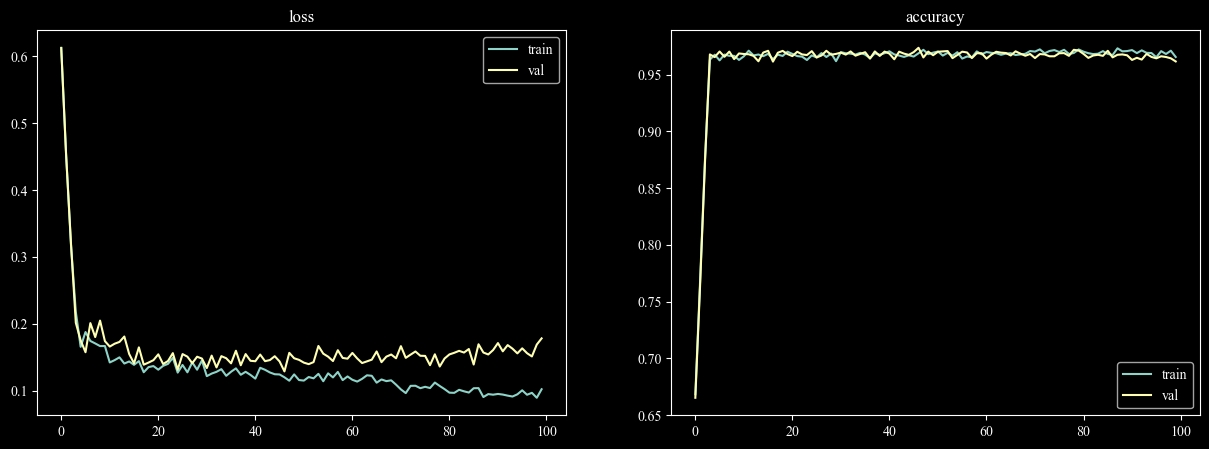

In [16]:

params, metrics = src.train(params, metrics, conf, args, train_loader, val_loader)
src.plot_metrics(metrics);

In [39]:
# Define input tensor and kernel tensor
# x = jnp.zeros((1, 3, 32, 32))  # batch_size = 1, channels = 3, height = 32, width = 32
# w = jnp.zeros((16, 3, 4, 4))   # out_channels = 16, in_channels = 3, kernel_height = 4, kernel_width = 4
conv = lambda x, w, d: jax.lax.conv_general_dilated(x, w, [1 for _ in range(d)], padding='SAME')
conv2d = lambda x, w: conv(x, w, 2)
conv3d = lambda x, w: conv(x, w, 3)

x, _, _, _ = next(train_loader)
w = jax.random.normal(rng, (16, 3, 4, 4)) * jnp.sqrt(2 / 3)

# Perform 2D convolution
y = conv2d(x, w)
print('x.shape:', x.shape, 'w.shape:', w.shape, 'y.shape:', y.shape)


x.shape: (32, 3, 32, 32) w.shape: (16, 3, 4, 4) y.shape: (32, 16, 32, 32)


In [47]:
x, y, _, _ = next(train_loader)
kernel = random.normal(rng, (4, 4, 3))

In [48]:
x[0].shape, kernel.shape

((32, 32, 3), (4, 4, 3))

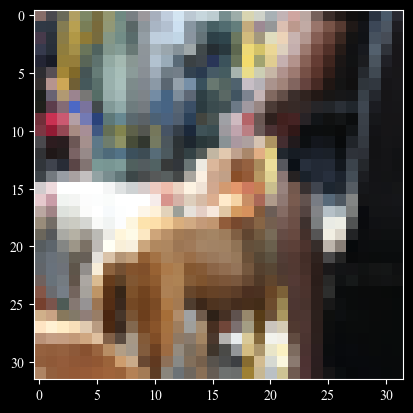

In [25]:
plt.imshow(x[0])